In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook is largely based on the Course 3 of the coursera [Tensorflow in Practice Specialization](https://github.com/lmoroney/dlaicourse/tree/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP://)

Training music code is taken from [here](https://soundcloud.com/user-195236670://) , kudos to scrbnmac for his great work writing sonic Pi music

In [0]:
from google.colab import files
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import io

Now we need some training data, I have selected this nice track by Purcell, https://gist.github.com/rbnpi/8785fd93087ca115ff2799f8bd72153c   
Code basically follows this pattern:

```
a1=[]
b1=[]
a1[0]=[:C3,:B2,:G2,:r,:r,...,:Ef5,:D5,:Ef5,:C3,:B2,:G2,:r,:r,:Bf3,:Ef3,:D3,:B2,:C3,:Ef3,:F3,:G3,:r]
b1[0]=[0.5,0.5...2.0]
c1=[70]
in_thread do
  for i in 0..a1.length-1
    use_bpm c1[i]
    for j in 0..a1[i].length-1
      play a1[i][j],sustain: b1[i][j]*0.9,release: b1[i][j]*0.1
      sleep b1[i][j]
    end
  end
end
```
Where
*   **a**  is the notes list
*   **b** is the notes duration list
*   **c** is the BPM

To make things easier we are going to learn the notes list, leaving the duration and the bpm static.
So I have created a training set extracting the notes list. Training data is on the train_data.rb file



In [8]:
file_uploaded = files.upload()
data = str(file_uploaded['train_data.rb'])
corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

Saving train_data.rb to train_data (1).rb


Our model present a canonical architecture for text generation. 

In [9]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1225, 100)         3400      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1225, 300)         301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1225, 300)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1717      
_________________________________________________________________
dense_3 (Dense)              (None, 34)                612       
Total params: 467,329
Trainable params: 467,329
Non-trainable params: 0
________________________________________________

In [20]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
39/39 [==============================] - 6s 155ms/step - loss: 1.9566 - accuracy: 0.4727
Epoch 2/100
39/39 [==============================] - 6s 153ms/step - loss: 1.9274 - accuracy: 0.4653
Epoch 3/100
39/39 [==============================] - 6s 154ms/step - loss: 1.9002 - accuracy: 0.4710
Epoch 4/100
39/39 [==============================] - 6s 153ms/step - loss: 1.8790 - accuracy: 0.4702
Epoch 5/100
39/39 [==============================] - 6s 153ms/step - loss: 1.8798 - accuracy: 0.4800
Epoch 6/100
39/39 [==============================] - 6s 155ms/step - loss: 1.8838 - accuracy: 0.4767
Epoch 7/100
39/39 [==============================] - 6s 156ms/step - loss: 1.8527 - accuracy: 0.4833
Epoch 8/100
39/39 [==============================] - 6s 155ms/step - loss: 1.8297 - accuracy: 0.4833
Epoch 9/100
39/39 [==============================] - 6s 154ms/step - loss: 1.8172 - accuracy: 0.4767
Epoch 10/100
39/39 [==============================] - 6s 155ms/step - loss: 1.8078 - accura

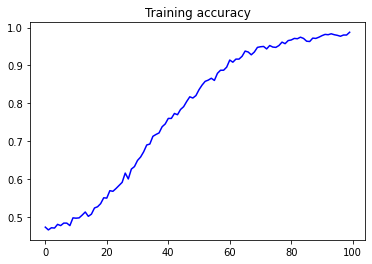

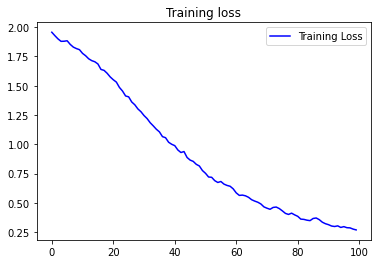

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

These are pretty neat training metrics.
Lets add some random seed to start our composition ..

In [34]:
seed_text = ":Af5,:c4"
next_words = 500
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word

:Af5,:c4 g5 f5 g5 f5 ef5 d5 c5 f3 r f3 r bf5 af5 r b3 r af5 g5 r a3 r g5 d5 ef5 f5 g5 ef5 d5 c5 c3 c3 b2 g2 r r bf3 ef3 d3 b2 r ef4 r r c4 r g3 r f3 r bf3 r c4 r b3 r r g3 ef4 d4 c4 r c3 r r g4 r c4 ef4 r r f4 ef3 d3 b2 c3 ef3 f3 g3 r r r r r g3 r c3 r r g4 r c4 ef4 r r f4 ef3 d3 b2 r r g3 r r r r r b2 g2 r r bf3 ef3 d3 b2 r g5 g5 g5 f5 f5 f5 ef5 af5 g5 f5 bf5 af5 g5 af5 g5 f5 g5 f5 ef5 d5 ef5 c3 b2 g2 r r bf3 ef3 d3 b2 c3 ef3 f3 g3 r n r af2 f2 f4 r r ef4 c4 d4 r r c3 r g3 r r bf3 r c4 r b3 r r af2 f2 f4 r c3 ef3 r g3 r r r r r r d3 g3 r c3 f3 r bf3 r r r r r r r d3 g3 r c3 f3 r bf3 r r r r r r r d3 g3 r c3 f3 r bf3 r r r r r r r d3 g3 r c3 f3 r bf3 r r r r r r r d3 g3 r c3 f3 r bf3 r r r r r r r c4 r g3 r f3 r bf3 r c4 r b3 r r g3 r g3 c4 r r g4 r r af4 bf2 bf2 r b3 r c4 r a3 b3 r r c4 r g3 r f3 r bf3 r c4 r b3 r r g3 r g3 c4 r r g4 r r af4 bf2 bf2 r b3 r c4 r a3 b3 r r c4 r g3 r r bf3 r r c4 r b3 r r g3 r r ef4 r r r f4 ef3 bf2 ef3 r g4 g3 r r ef4 r r r r r g3 r r d3 g3 r c3 f3 r r 

And some final editing for making easier to copy and paste the code

In [36]:
notes_list = seed_text.split()
sonic_pi_vector_temp = "["
for note in notes_list:
  sonic_pi_vector_temp += ":"+note+","
sonic_pi_vector_temp += "]"
print(sonic_pi_vector_temp) 

[::Af5,:c4,:g5,:f5,:g5,:f5,:ef5,:d5,:c5,:f3,:r,:f3,:r,:bf5,:af5,:r,:b3,:r,:af5,:g5,:r,:a3,:r,:g5,:d5,:ef5,:f5,:g5,:ef5,:d5,:c5,:c3,:c3,:b2,:g2,:r,:r,:bf3,:ef3,:d3,:b2,:r,:ef4,:r,:r,:c4,:r,:g3,:r,:f3,:r,:bf3,:r,:c4,:r,:b3,:r,:r,:g3,:ef4,:d4,:c4,:r,:c3,:r,:r,:g4,:r,:c4,:ef4,:r,:r,:f4,:ef3,:d3,:b2,:c3,:ef3,:f3,:g3,:r,:r,:r,:r,:r,:g3,:r,:c3,:r,:r,:g4,:r,:c4,:ef4,:r,:r,:f4,:ef3,:d3,:b2,:r,:r,:g3,:r,:r,:r,:r,:r,:b2,:g2,:r,:r,:bf3,:ef3,:d3,:b2,:r,:g5,:g5,:g5,:f5,:f5,:f5,:ef5,:af5,:g5,:f5,:bf5,:af5,:g5,:af5,:g5,:f5,:g5,:f5,:ef5,:d5,:ef5,:c3,:b2,:g2,:r,:r,:bf3,:ef3,:d3,:b2,:c3,:ef3,:f3,:g3,:r,:n,:r,:af2,:f2,:f4,:r,:r,:ef4,:c4,:d4,:r,:r,:c3,:r,:g3,:r,:r,:bf3,:r,:c4,:r,:b3,:r,:r,:af2,:f2,:f4,:r,:c3,:ef3,:r,:g3,:r,:r,:r,:r,:r,:r,:d3,:g3,:r,:c3,:f3,:r,:bf3,:r,:r,:r,:r,:r,:r,:r,:d3,:g3,:r,:c3,:f3,:r,:bf3,:r,:r,:r,:r,:r,:r,:r,:d3,:g3,:r,:c3,:f3,:r,:bf3,:r,:r,:r,:r,:r,:r,:r,:d3,:g3,:r,:c3,:f3,:r,:bf3,:r,:r,:r,:r,:r,:r,:r,:d3,:g3,:r,:c3,:f3,:r,:bf3,:r,:r,:r,:r,:r,:r,:r,:c4,:r,:g3,:r,:f3,:r,:bf3,:r,:c4,

In [0]:
How will it sound? Cannot wait!